<a href="https://colab.research.google.com/github/praveentn/ml-repos/blob/master/Notebooks/Algorithms/Boson_Sampling_0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum advantage with Gaussian Boson Sampling

In [1]:
# near-term quantum advantage

# https://pennylane.ai/qml/demos/tutorial_gbs.html

Author: PennyLane dev team. Posted: 4 Dec 2020. Last updated: 4 Dec 2020.

On the journey to large-scale fault-tolerant quantum computers, one of the first major milestones is to demonstrate a quantum device carrying out tasks that are beyond the reach of any classical algorithm. The Google Quantum team was the first to claim this achievement, announced in their paper Quantum supremacy using a programmable superconducting processor [1]. Now a team led by Chao-Yang Lu and Jian-Wei Pan has performed a similar feat using quantum photonics. While Google’s experiment performed the task of random circuit sampling using a superconducting processor, the new experiment, published in the paper Quantum computational advantage using photons [2] leverages the quantum properties of light to tackle a task called Gaussian Boson Sampling (GBS).

This tutorial will walk you through the basic elements of GBS, motivate why it is classically challenging, and show you how to explore GBS using PennyLane and the photonic quantum devices accessible via the PennyLane-Strawberry Fields plugin. If you are interested in possible applications of GBS, or want to access programmable GBS hardware via the cloud, check out the Strawberry Fields website for more details.

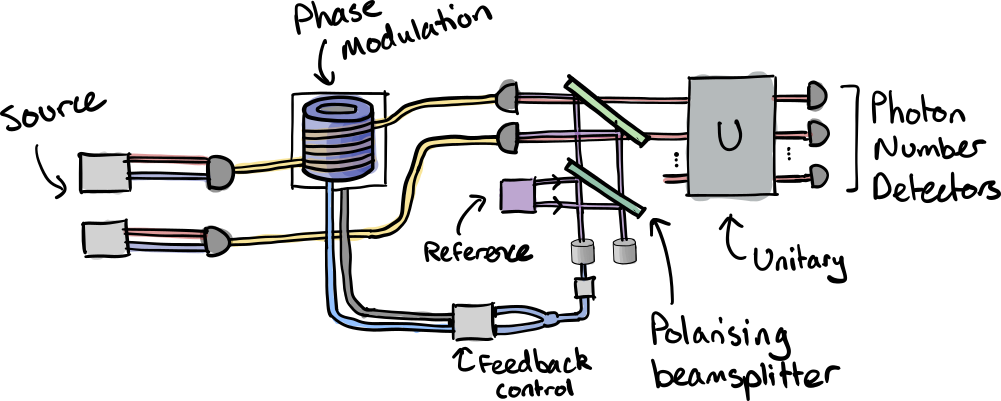

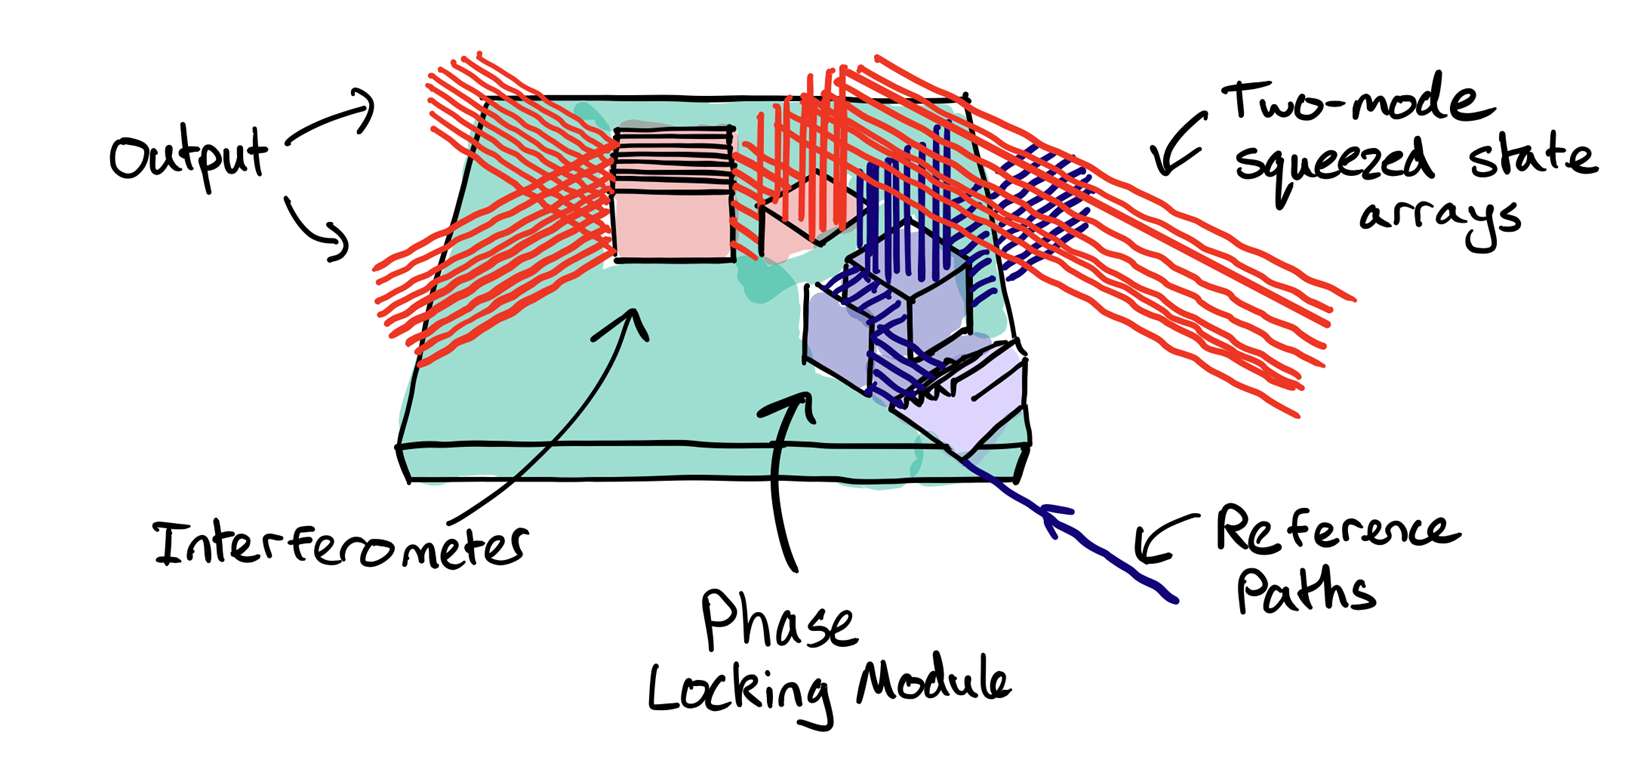

Illustration of the experimental setup used by Zhong et al. in Quantum computational advantage using photons [2].

*italicized text*

## The origins of GBS

Let’s first explain the name. Boson refers to bosonic matter, which, along with fermions, makes up one of the two elementary classes of particles. The most prevalent bosonic system in our everyday lives is light, which is made of particles called photons. Another famous example, though much harder to find, is the Higgs boson. The distinguishing characteristic of bosons is that they follow “Bose-Einstein statistics”, which very loosely means that the particles like to bunch together (contrast this to fermionic matter like electrons, which must follow the Pauli Exclusion Principle and keep apart).

This property can be observed in simple interference experiments such as the Hong-Ou Mandel setup. If two single photons are interfered on a balanced beamsplitter, they will both emerge at the same output port—there is zero probability that they will emerge at separate outputs. This is a simple but notable quantum property of light; if electrons were brought together in a similar experiement, they would always appear at separate output ports.

Gaussian Boson Sampling [3] is, in fact, a member of a larger family of “Boson Sampling” algorithms, stemming back to the initial proposal of Aaronson and Arkhipov [4] in 2013. Boson Sampling is quantum interferometry writ large. Aaronson and Arkhipov’s original proposal was to inject many single photons into distinct input ports of a large interferometer, then measure which output ports they appear at. The natural interference properties of bosons means that photons will appear at the output ports in very unique and specific ways. Boson Sampling was not proposed with any kind of practical real-world use-case in mind. Like the random circuit sampling, it’s just a quantum system being its best self. With sufficient size and quality, it is strongly believed to be hard for a classical computer to simulate this efficiently.

Finally, the “Gaussian” in GBS refers to the fact that we modify the original Boson Sampling proposal slightly: instead of injecting single photons—which are hard to jointly create in the size and quality needed to demonstrate Boson Sampling conclusively—we instead use states of light that are experimentally less demanding (though still challenging!). These states of light are called Gaussian states, because they bear strong connections to the Gaussian (or Normal) distribution from statistics. In practice, we use a particular Gaussian state called a squeezed state for the inputs, since these are arguably the most non-classical of Gaussian states.

#### Note

While computationally hard to simulate, Boson Sampling devices, on their own, are not capable of universal quantum computing. However, in combination with other components, GBS is a key building block for a universal device [5].

In [2]:
# [5] https://pennylane.ai/qml/demos/tutorial_gbs.html#bourassa2020

In [3]:
import numpy as np

# set the random seed
np.random.seed(42)

In [4]:
# !pip install pennylane
# !pip install thewalrus
# !pip install pennylane_qiskit
# !pip install pennylane-sf --upgrade

## Coding a GBS algorithm

The researchers in [2] experimentally demonstrate a GBS device by preparing 50 squeezed states and injecting them into a 100-mode interferometer. In this demo, in order to keep things classically simulable, we will stick to a much simpler setting consisting of 4 squeezed states injected into a 4-mode interferometer. At a high level, an interferometer on N modes can be represented using an N×N unitary matrix U. When decomposed into a quantum optical circuit, the interferometer will be made up of beamsplitters and phase shifters.

[2] https://pennylane.ai/qml/demos/tutorial_gbs.html#zhong2020

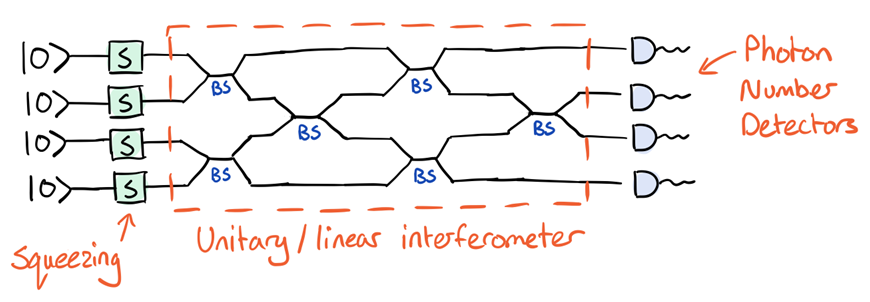

Simulating this circuit using PennyLane is easy; we can simply read off the gates from left to right, and convert it into a QNode.

In [5]:
# import PennyLane
import pennylane as qml
from pennylane.devices.default_qubit import DefaultQubit
from pennylane_qiskit import AerDevice

qml.about()

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Name: PennyLane
Version: 0.18.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: None
Author-email: None
License: Apache License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, toml, numpy, semantic-version, autoray, autograd, cachetools, appdirs, pennylane-lightning, networkx
Required-by: PennyLane-SF, PennyLane-qiskit, PennyLane-Lightning
Platform info:           Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
Python version:          3.7.12
Numpy version:           1.19.5
Scipy version:           1.4.1
Installed devices:
- default.gaussian (PennyLane-0.18.0)
- default.mixed (PennyLane-0.18.0)
- default.qubit (PennyLane-0.18.0)
- default.qubit.autograd (PennyLane-0.18.0)
- default.qubit.jax (PennyLane-0.18.0)
- default.qubit.tf (PennyLane-0.18.0)
- default.qubit.torch (PennyLane-0.18.0)
- default.tensor (PennyLane-0.18.0)
- default.tensor.tf (PennyLane-0.18.0)
- strawberryfield

We must define the unitary matrix we would like to embed in the circuit. We will use SciPy to generate a Haar-random unitary:



In [6]:
from scipy.stats import unitary_group

# define the linear interferometer
U = unitary_group.rvs(4)
print(U)

[[ 0.23648826-0.48221431j  0.06829648+0.04447898j  0.51150074-0.09529866j
   0.55205719-0.35974699j]
 [-0.11148167+0.69780321j -0.24943828+0.08410701j  0.46705929-0.43192981j
   0.16220654-0.01817602j]
 [-0.22351926-0.25918352j  0.24364996-0.05375623j -0.09259829-0.53810588j
   0.27267708+0.66941977j]
 [ 0.11519953-0.28596729j -0.90164923-0.22099186j -0.09627758-0.13105595j
  -0.0200152 +0.12766128j]]


We can now use this to construct the circuit, choosing a compatible device. For the simulation, we can use the Strawberry Fields Gaussian backend. This backend is perfectly suited for simulation of GBS, as the initial states are Gaussian, and all gates transform Gaussian states to other Gaussian states.

In [7]:
n_wires = 4
cutoff = 10

dev = qml.device("strawberryfields.gaussian", wires=n_wires, cutoff_dim=cutoff)

@qml.qnode(dev)
def gbs_circuit():
    # prepare the input squeezed states
    for i in range(n_wires):
        qml.Squeezing(1.0, 0.0, wires=i)

    # linear interferometer
    qml.Interferometer(U, wires=range(n_wires))
    return qml.probs(wires=range(n_wires))

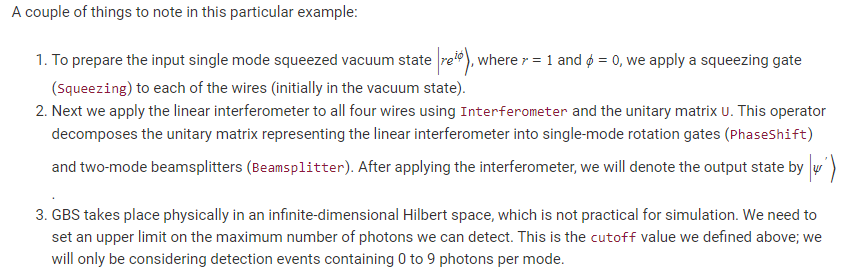


We can now execute the QNode, and extract the resulting probability distribution:

In [8]:
probs = gbs_circuit().reshape([cutoff] * n_wires)
print(probs.shape)

(10, 10, 10, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: 'Interferometer' is deprecated and will be renamed 'InterferometerUnitary'


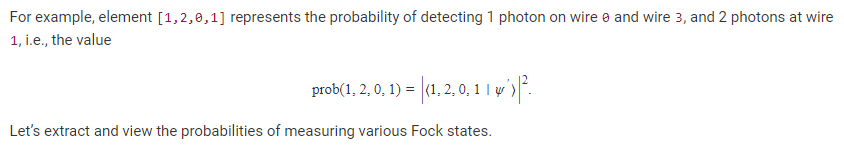

In [9]:
# Fock states to measure at output
measure_states = [(0,0,0,0), (1,1,0,0), (0,1,0,1), (1,1,1,1), (2,0,0,0)]

# extract the probabilities of calculating several
# different Fock states at the output, and print them out
for i in measure_states:
    print(f"|{''.join(str(j) for j in i)}>: {probs[i]}")

|0000>: 0.17637844761413501
|1100>: 0.034732936494202823
|0101>: 0.011870900427255577
|1111>: 0.005957399165336117
|2000>: 0.02957384308320544


# GBS Distribution

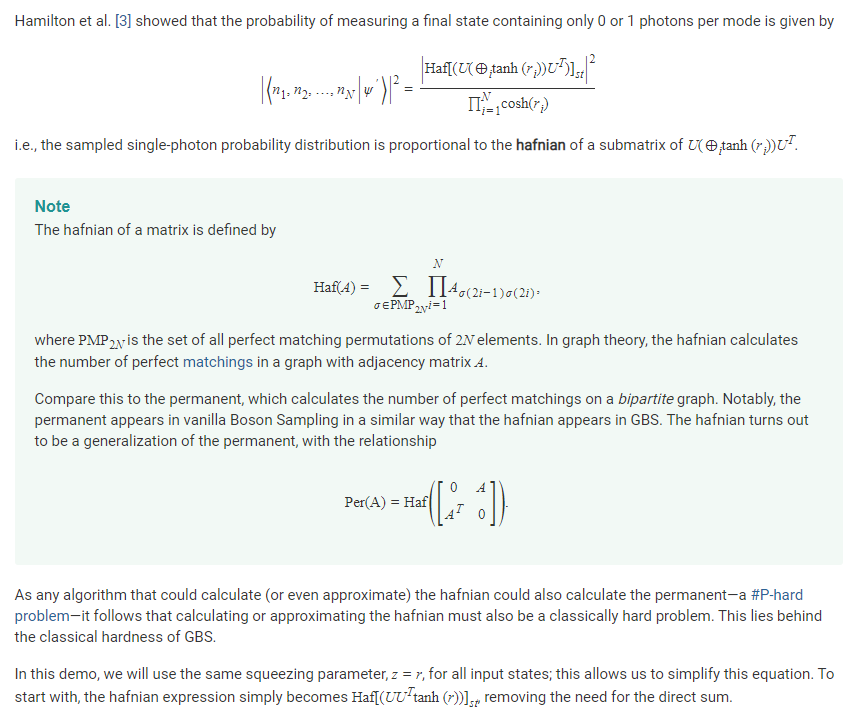

In [10]:
# [3] https://pennylane.ai/qml/demos/tutorial_gbs.html#hamilton2017

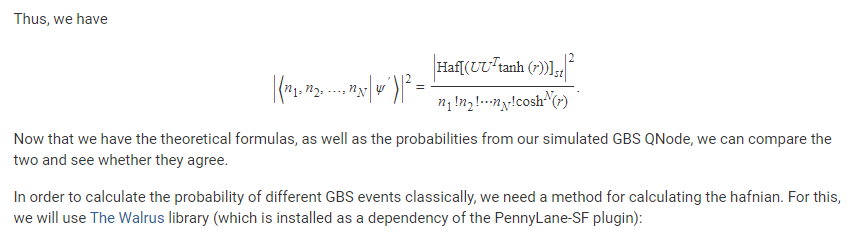

In [11]:
from thewalrus import hafnian as haf

Now, for the right-hand side numerator, we first calculate the submatrix

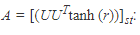



In [12]:
A = (np.dot(U, U.T) * np.tanh(1))
A

array([[ 0.19343159-0.54582922j,  0.43418269-0.09169615j,
         0.10197746+0.04470744j, -0.14414193-0.12075801j],
       [ 0.43418269-0.09169615j, -0.27554025-0.46222197j,
        -0.05312304-0.15298905j,  0.24957327+0.07082907j],
       [ 0.10197746+0.04470744j, -0.05312304-0.15298905j,
        -0.46875602+0.42222464j, -0.36857907+0.08685281j],
       [-0.14414193-0.12075801j,  0.24957327+0.07082907j,
        -0.36857907+0.08685281j,  0.5116576 +0.26865451j]])

In GBS, we determine the submatrix by taking the rows and columns corresponding to the measured Fock state. For example, to calculate the submatrix in the case of the output measurement |1,1,0,0⟩, we have

In [13]:
print(A[:, [0, 1]][[0, 1]])

[[ 0.19343159-0.54582922j  0.43418269-0.09169615j]
 [ 0.43418269-0.09169615j -0.27554025-0.46222197j]]


i.e., we consider only the rows and columns where a photon was detected, which gives us the submatrix corresponding to indices 0 and 1.

# Comparing to simulation

Now that we have a method for calculating the hafnian, let’s compare the output to that provided by the PennyLane QNode.

### Measuring |0,0,0,0⟩ at the output

This corresponds to the hafnian of an empty matrix, which is simply 1:

In [14]:
print(1 / np.cosh(1) ** 4)
print(probs[0, 0, 0, 0])

0.1763784476141347
0.17637844761413501


### Measuring |1,1,0,0⟩ at the output

In [15]:
A = (np.dot(U, U.T) * np.tanh(1))[:, [0, 1]][[0, 1]]

print(np.abs(haf(A)) ** 2 / np.cosh(1) ** 4)
print(probs[1, 1, 0, 0])

0.03473293649420271
0.034732936494202823


### Measuring |0,1,0,1⟩ at the output

In [16]:
A = (np.dot(U, U.T) * np.tanh(1))[:, [1, 3]][[1, 3]]

print(np.abs(haf(A)) ** 2 / np.cosh(1) ** 4)
print(probs[0, 1, 0, 1])

0.011870900427255558
0.011870900427255577


### Measuring |1,1,1,1⟩ at the output

This corresponds to the hafnian of the full matrix


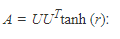



In [17]:
A = (np.dot(U, U.T) * np.tanh(1))

print(np.abs(haf(A)) ** 2 / np.cosh(1) ** 4)
print(probs[1, 1, 1, 1])

0.005957399165336081
0.005957399165336117


### Measuring |2,0,0,0⟩ at the output

Since we have two photons in mode q[0], we take two copies of the first row and first column, making sure to divide by 2!:

In [18]:
A = (np.dot(U, U.T) * np.tanh(1))[:, [0, 0]][[0, 0]]

print(np.abs(haf(A)) ** 2 / (2 * np.cosh(1) ** 4))
print(probs[2, 0, 0, 0])

0.02957384308320539
0.02957384308320544


The PennyLane simulation results agree (with almost negligible numerical error) to the expected result from the Gaussian boson sampling equation!

This demo provides an entry-level walkthrough to the ideas behind GBS, providing you with the basic code needed for exploring the ideas behind the photonic quantum advantage paper. Try changing the number of modes, the number of injected squeezed states, or the cutoff dimension, and see how each of these affect the classical computation time. If you’re interested in learning more about GBS, or about photonic quantum computing in general, the Strawberry Fields website is a great resource.

## References

[1]
Arute, F., Arya, K., Babbush, R., et al. “Quantum supremacy using a programmable superconducting processor” Nature 574, 505-510 (2019).

[2]
(1, 2, 3) Zhong, H.-S., Wang, H., Deng, Y.-H., et al. (2020). Quantum computational advantage using photons. Science, 10.1126/science.abe8770.

[3]
(1, 2) Craig S. Hamilton, Regina Kruse, Linda Sansoni, Sonja Barkhofen, Christine Silberhorn, and Igor Jex. Gaussian boson sampling. Physical Review Letters, 119:170501, Oct 2017. arXiv:1612.01199, doi:10.1103/PhysRevLett.119.170501.

[4]
Scott Aaronson and Alex Arkhipov. The computational complexity of linear optics. Theory of Computing, 9(1):143–252, 2013. doi:10.4086/toc.2013.v009a004.

[5]
Bourassa, J. E., Alexander, R. N., Vasmer, et al. (2020). Blueprint for a scalable photonic fault-tolerant quantum computer. arXiv preprint arXiv:2010.02905.